# Machine Learning Analysis - London Housing Data

This notebook will apply supervised ML models from scikit-learn to analyse the real estate data in ```10m_london_houses_.csv```.

Exploratory data analysis of this dataset is covered in ```EDA.ipynb```.

The goal of this notebook is to try out some simple ML models and test best ML practices using a straightforward dataset. This includes
- Apply regression models (Linear, Logistic, Ridge and Lasso) to predict house prices.
- Apply KNN to predict whether or not a house has a garage/ garden.
- Perform k-fold cross validation.
- Evaluate model performance with all available metrics: ROC/ AUC curves, accuracy, precision, F1-score, R^2, MSE, RMSE, NMSE confusion matrices.
- Perform hyperparameter tuning with GridSearchCV and RandomSearchCV to optimize models.
- Convert categorical data to numerical data.
- Evaluate the effect of scaling/ normalization on model performance.
- Automate model building with pipelines.
- Principal component analysis - [Geeksforgeeks](https://www.geeksforgeeks.org/data-analysis/principal-component-analysis-with-python/)

Repository link: [Github](https://github.com/rsamconn/London-housing)

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print(np.NaN)

nan


In [2]:
# Load the data
housing_df = pd.read_csv('data/10m_london_houses_.csv')

# Reminder of how the data looks
print(f"Dataset shape: {housing_df.shape}")
display(housing_df.head())

Dataset shape: (1000, 17)


,Address,Neighborhood,Bedrooms,Bathrooms,Square Meters,Building Age,Garden,Garage,Floors,Property Type,Heating Type,Balcony,Interior Style,View,Materials,Building Status,Price (£)
0,78 Regent Street,Notting Hill,2,3,179,72,No,No,3,Semi-Detached,Electric Heating,High-level Balcony,Industrial,Garden,Marble,Renovated,2291200
1,198 Oxford Street,Westminster,2,1,123,34,Yes,No,1,Apartment,Central Heating,High-level Balcony,Industrial,City,Laminate Flooring,Old,1476000
2,18 Regent Street,Soho,5,3,168,38,No,Yes,3,Semi-Detached,Central Heating,No Balcony,Industrial,Street,Wood,Renovated,1881600
3,39 Piccadilly Circus,Islington,5,1,237,53,Yes,Yes,1,Apartment,Underfloor Heating,No Balcony,Classic,Park,Granite,Renovated,1896000
4,116 Fleet Street,Marylebone,4,1,127,23,No,Yes,2,Semi-Detached,Central Heating,No Balcony,Modern,Park,Wood,Old,1524000


In [4]:
# No longer needed
# pip install scikit-learn

## 1. KNNs for binary classification

In [3]:
# Test a KNN model
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)

In [70]:
# First we need to prep the data a bit

# Create column where Garage is 0 or 1 instead of Yes/ No
housing_df['Garage_val'] = housing_df['Garage'].replace({"No": 0, "Yes": 1})
housing_df['Garden_val'] = housing_df['Garden'].replace({"No": 0, "Yes": 1})

# Test the KNN with just a few columns first
X = housing_df[['Bedrooms', 'Square Meters', 'Building Age']].values
y = housing_df['Garage_val'].values

# Perform test-train split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=55, stratify=y)

# Check the size of our new datasets
datasets = [X_train, X_test, y_train, y_test]
for set in datasets:
    print(set.shape)

# housing_df.head()

(700, 3)
(300, 3)
(700,)
(300,)


In [44]:
# Test the model on the data
knn.fit(X_train, y_train)

knn.predict(X_test)

knn.score(X_test, y_test)

0.49333333333333335

Quite terrible performance - basically random chance!

In [45]:
# Loop over multiple neighbor values to find the optimal value
train_accuracies = {}
test_accuracies = {}
neighbors = np.arange(1, 20)
for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors = n)
    knn.fit(X_train, y_train)
    train_accuracies[n] = knn.score(X_train, y_train)
    test_accuracies[n] = knn.score(X_test, y_test)

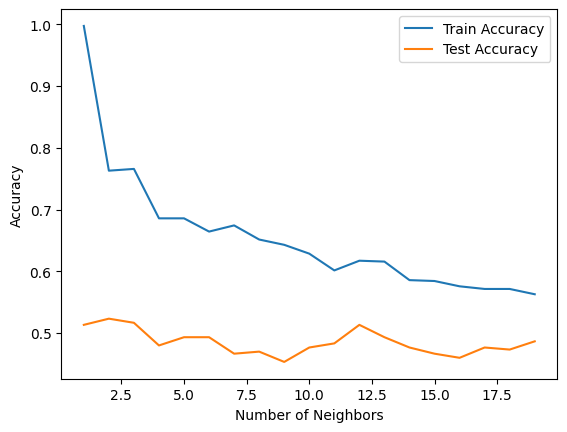

In [46]:
# Plot the train and test accuracies
plt.plot(neighbors, list(train_accuracies.values()), label='Train Accuracy')
plt.plot(neighbors, list(test_accuracies.values()), label='Test Accuracy')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Tragically, the KNN doesn't get much better than random chance when using just these 3 variables.

Perhaps it can do better if we add more?

In [83]:


# Do train-test split for a subset of columns
numeric_columns = ['Bedrooms', 'Bathrooms', 'Square Meters', 'Building Age', 'Floors']
X_numeric = housing_df[numeric_columns].values
y_garage = housing_df['Garage_val'].values
X_numeric_train, X_numeric_test, y_garage_train, y_garage_test = train_test_split(X_numeric, y_garage, test_size=0.3, random_state=55, stratify=y)

y_garden = housing_df['Garden_val'].values
X_numeric_train, X_numeric_test, y_garden_train, y_garden_test = train_test_split(X_numeric, y_garden, test_size=0.3, random_state=55, stratify=y)

print(Xsub_train.shape, Xsub_test.shape, ysub_train.shape, ysub_test.shape)

(700, 5) (300, 5) (700,) (300,)


In [ ]:
# Loop over n columns - in each loop, add another column and calculate KNN scores for 1-20 neighbors. Show the results on a grid of plots
def build_knns(cols, N, X_train, X_test, y_train, y_test):
    '''Takes in a list of columns, an integer N and a train-test split of features and targets
    Prepares a figure
    Loops over the number of columns - for each loop, i:
        Take a subset of the first i columns of features
        Loop over N:
            Create N KNNs with neighbors 1-N
            Each uses the subset of features
            Plot the train and test accuracies of each KNN on a figure quadrant
    '''

    # Prepare figure
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    count = 0
    # Loop over the column list
    for i in range(len(cols)):
        count += 1
        col_subset = cols[:i+1]
        # print(f'Using {count} columns')
        # print(col_subset)

        Xsub_train = X_train[:, :i+1]
        Xsub_test = X_test[:, :i+1]

        # Loop over multiple neighbor values to find the optimal value
        train_accuracies = {}
        test_accuracies = {}
        neighbors = np.arange(1, N)
        for n in neighbors:
            knn = KNeighborsClassifier(n_neighbors = n)
            knn.fit(Xsub_train, y_train)
            train_accuracies[n] = knn.score(Xsub_train, y_train)
            test_accuracies[n] = knn.score(Xsub_test, y_test)

        # Plot the train and test accuracies
        axes[i].plot(neighbors, list(train_accuracies.values()), label='Train Accuracy')
        axes[i].plot(neighbors, list(test_accuracies.values()), label='Test Accuracy')
        axes[i].set_xlabel('Number of Neighbors')
        axes[i].set_ylabel('Accuracy')
        axes[i].set_title(f'Accuracy with {i+1} columns')
        axes[i].legend()

    plt.tight_layout()
    # plt.legend()
    # plt.savefig(plotDir + 'scatter_plots.png', dpi=300, bbox_inches='tight')
    plt.show()

    return



(700, 5) (300, 5) (700,) (300,)


Using 1 columns
['Bedrooms']
Using 2 columns
['Bedrooms', 'Bathrooms']
Using 3 columns
['Bedrooms', 'Bathrooms', 'Square Meters']
Using 4 columns
['Bedrooms', 'Bathrooms', 'Square Meters', 'Building Age']
Using 5 columns
['Bedrooms', 'Bathrooms', 'Square Meters', 'Building Age', 'Floors']


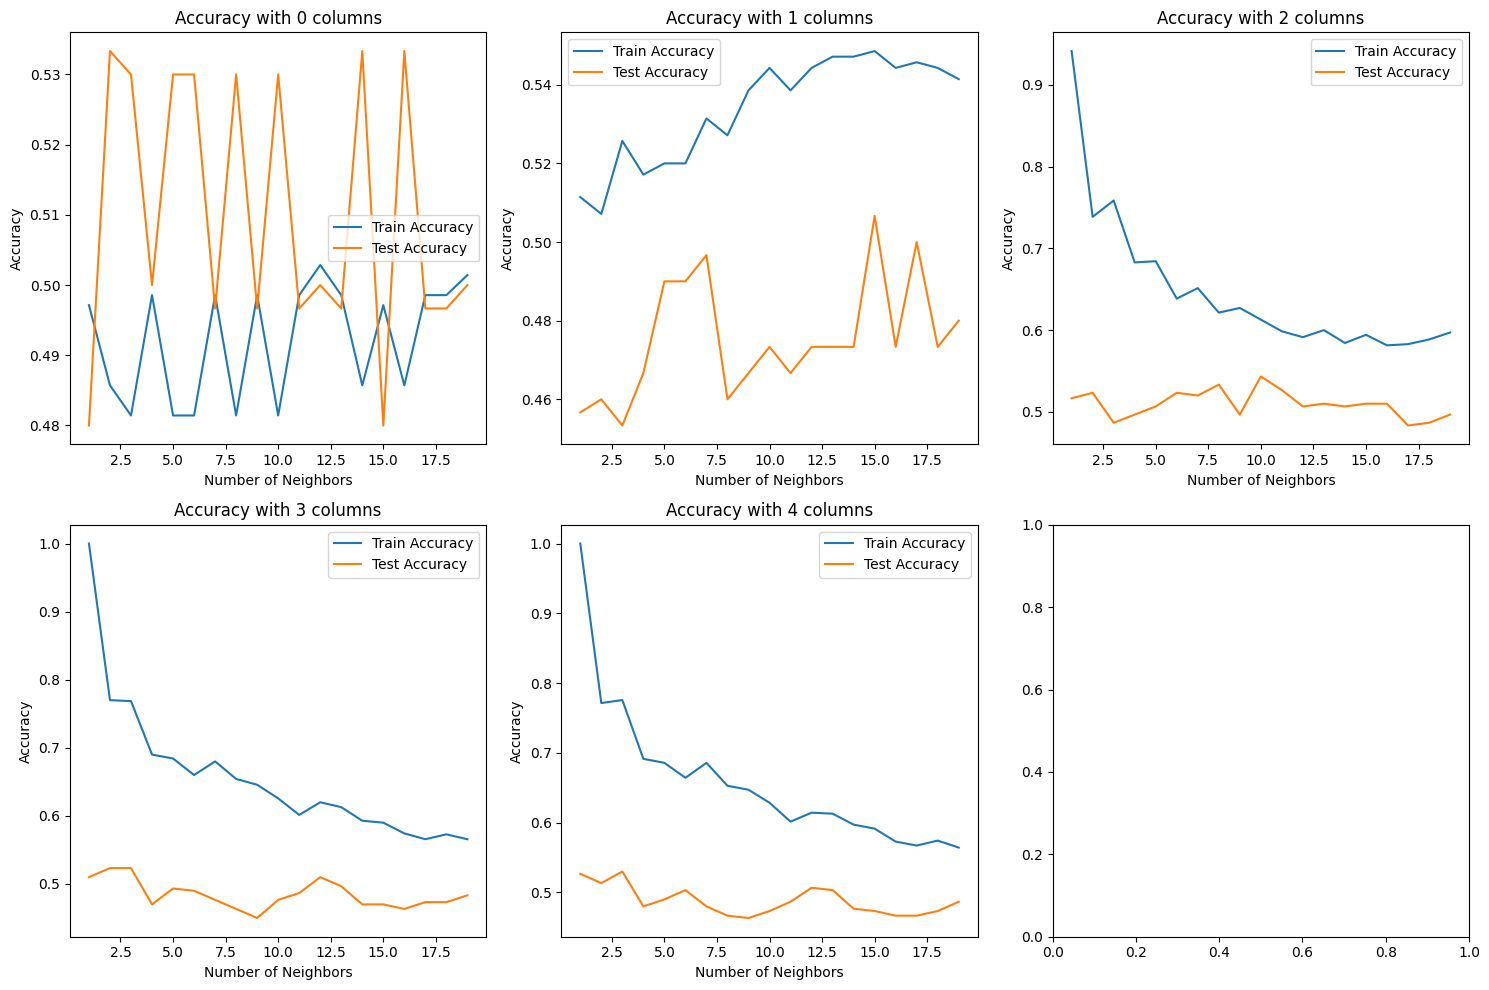

In [68]:
# Run build_knns on the bedrooms dataset
build_knns(numeric_columns[:5], 20, X5_train, X5_test, y_garage_train, y_garage_test)

Nope, still the same as random guessing.

### What about predicting gardens?

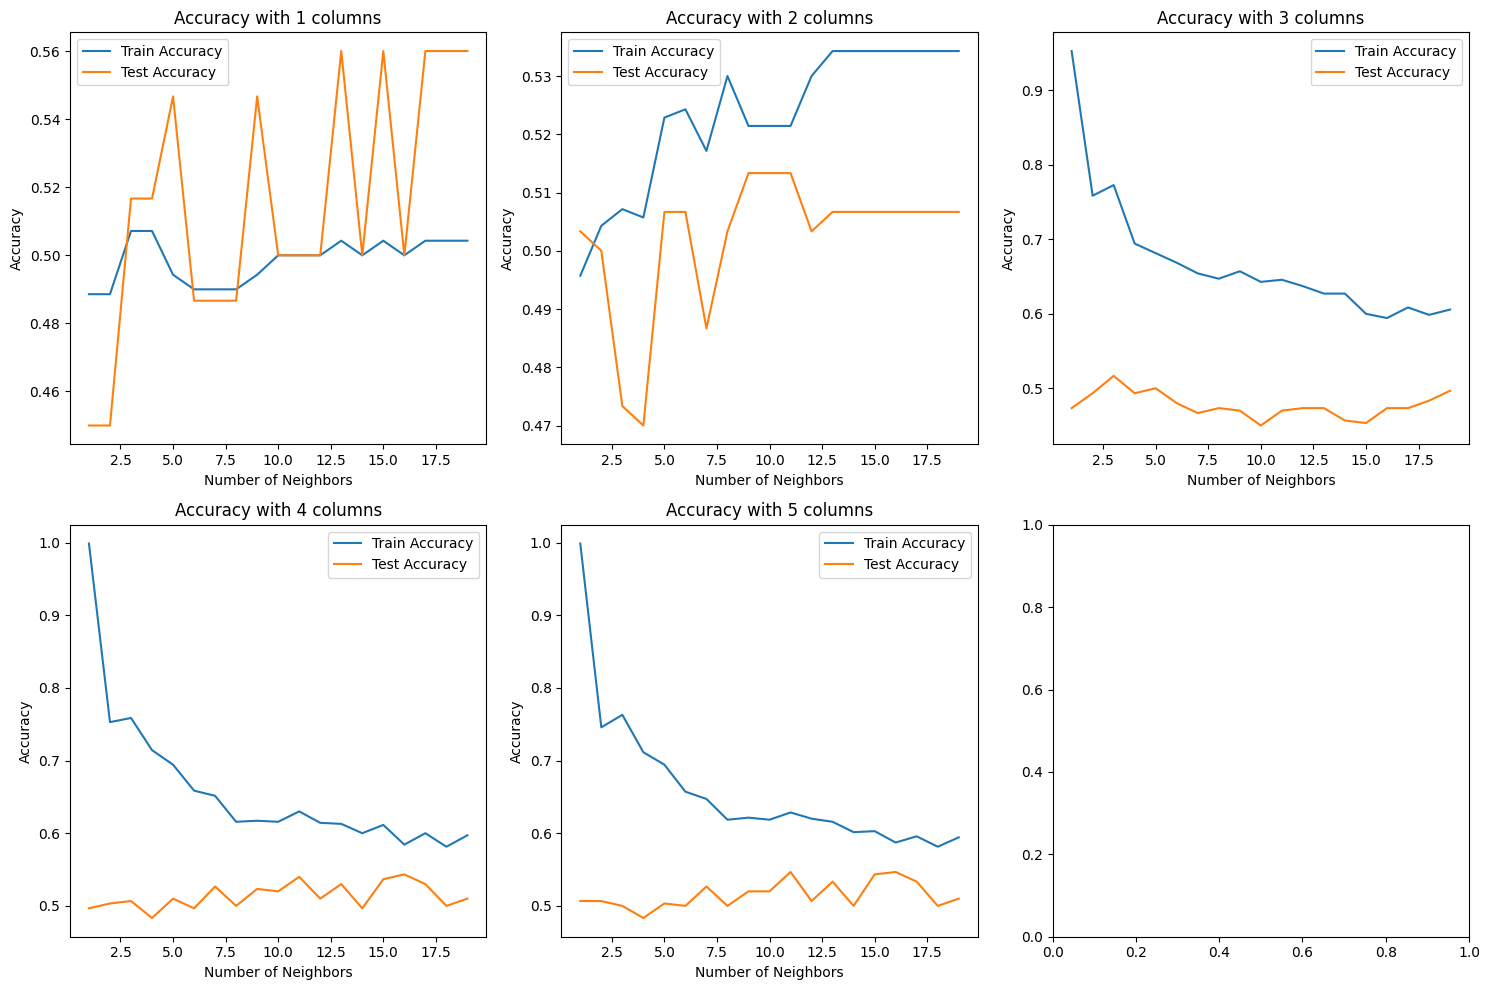

In [73]:
# Run build_knns
build_knns(numeric_columns[:5], 20, X5_train, X5_test, y_garden_train, y_garden_test)

No, not good predicting gardens either.

### 2.2 Logistic Regression